### Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
from torchvision import datasets, transforms, models  # datsets  , transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime

In [3]:
pip install nb_black

  Preparing metadata (setup.py) ... done
  Created wheel for nb_black: filename=nb_black-1.0.7-py3-none-any.whl size=5297 sha256=470895be389759296b71b9256ed5fe35fc625e6a1e72428a750c90dcbba32050
  Stored in directory: /root/.cache/pip/wheels/1e/b2/88/51c66d23ea5fd0d40ed50997555e15d981d92671376a9a412a
Successfully built nb_black
Note: you may need to restart the kernel to use updated packages.


In [4]:
%load_ext nb_black

<IPython.core.display.Javascript object>

### Import Dataset

<b> Dataset Link (Plant Vliiage Dataset ):</b><br> <a href='https://data.mendeley.com/datasets/tywbtsjrjv/1'> https://data.mendeley.com/datasets/tywbtsjrjv/1 </a> 

In [5]:
transform = transforms.Compose(
    [transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor()]
)

<IPython.core.display.Javascript object>

In [6]:
dataset = datasets.ImageFolder("/kaggle/input/mepco-tropic-leaf/MepcoTropicLeaf-V1/Database", transform=transform)

<IPython.core.display.Javascript object>

In [7]:
dataset

Dataset ImageFolder
    Number of datapoints: 3777
    Root location: /kaggle/input/mepco-tropic-leaf/MepcoTropicLeaf-V1/Database
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

<IPython.core.display.Javascript object>

In [8]:
indices = list(range(len(dataset)))

<IPython.core.display.Javascript object>

In [9]:
split = int(np.floor(0.85 * len(dataset)))  # train_size

<IPython.core.display.Javascript object>

In [10]:
validation = int(np.floor(0.70 * split))  # validation

<IPython.core.display.Javascript object>

In [11]:
print(0, validation, split, len(dataset))

0 2247 3210 3777


<IPython.core.display.Javascript object>

In [12]:
print(f"length of train size :{validation}")
print(f"length of validation size :{split - validation}")
print(f"length of test size :{len(dataset)-validation}")

length of train size :2247
length of validation size :963
length of test size :1530


<IPython.core.display.Javascript object>

In [13]:
np.random.shuffle(indices)

<IPython.core.display.Javascript object>

### Split into Train and Test

In [14]:
train_indices, validation_indices, test_indices = (
    indices[:validation],
    indices[validation:split],
    indices[split:],
)

<IPython.core.display.Javascript object>

In [15]:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

<IPython.core.display.Javascript object>

In [16]:
targets_size = len(dataset.class_to_idx)

<IPython.core.display.Javascript object>

### Model

<b>Convolution Aithmetic Equation : </b>(W - F + 2P) / S + 1 <br>
W = Input Size<br>
F = Filter Size<br>
P = Padding Size<br>
S = Stride <br>

### Transfer Learning

In [ ]:
# model = models.vgg16(pretrained=True)

In [ ]:
# for params in model.parameters():
#     params.requires_grad = False

In [ ]:
# model

In [ ]:
# n_features = model.classifier[0].in_features
# n_features

In [ ]:
# model.classifier = nn.Sequential(
#     nn.Linear(n_features, 1024),
#     nn.ReLU(),
#     nn.Dropout(0.4),
#     nn.Linear(1024, targets_size),
# )

In [ ]:
# model

### Original Modeling

In [17]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            # conv2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            # conv3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            # conv4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(50176, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, K),
        )

    def forward(self, X):
        out = self.conv_layers(X)

        # Flatten
        out = out.view(-1, 50176)

        # Fully connected
        out = self.dense_layers(out)

        return out

<IPython.core.display.Javascript object>

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


<IPython.core.display.Javascript object>

In [19]:
model = CNN(targets_size)

<IPython.core.display.Javascript object>

In [20]:
model.to(device)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

<IPython.core.display.Javascript object>

In [21]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [22]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
       BatchNorm2d-3         [-1, 32, 224, 224]              64
            Conv2d-4         [-1, 32, 224, 224]           9,248
              ReLU-5         [-1, 32, 224, 224]               0
       BatchNorm2d-6         [-1, 32, 224, 224]              64
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,496
              ReLU-9         [-1, 64, 112, 112]               0
      BatchNorm2d-10         [-1, 64, 112, 112]             128
           Conv2d-11         [-1, 64, 112, 112]          36,928
             ReLU-12         [-1, 64, 112, 112]               0
      BatchNorm2d-13         [-1, 64, 112, 112]             128
        MaxPool2d-14           [-1, 64,

<IPython.core.display.Javascript object>

In [23]:
criterion = nn.CrossEntropyLoss()  # this include softmax + cross entropy loss
optimizer = torch.optim.Adam(model.parameters())

<IPython.core.display.Javascript object>

### Batch Gradient Descent

In [24]:
def batch_gd(model, criterion, train_loader, test_laoder, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for e in range(epochs):

        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
           
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            train_loss.append(loss.item())  # torch to numpy world
            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)

        validation_loss = []

        for inputs, targets in validation_loader:
            
            inputs, targets = inputs.to(device), targets.to(device)

            output = model(inputs)

            loss = criterion(output, targets)

            validation_loss.append(loss.item())  # torch to numpy world

        validation_loss = np.mean(validation_loss)

        train_losses[e] = train_loss

        dt = datetime.now() - t0

        print(f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Duration:{dt}")

    return train_losses

<IPython.core.display.Javascript object>

In [25]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=validation_sampler
)

<IPython.core.display.Javascript object>

In [26]:
train_losses = batch_gd(model, criterion, train_loader, validation_loader, 10)

Epoch : 1/10 Train_loss:6.355 Duration:0:01:59.997601
Epoch : 2/10 Train_loss:2.923 Duration:0:01:34.341753
Epoch : 3/10 Train_loss:2.339 Duration:0:01:34.716433
Epoch : 4/10 Train_loss:1.907 Duration:0:01:33.951422
Epoch : 5/10 Train_loss:1.864 Duration:0:01:34.217741
Epoch : 6/10 Train_loss:1.477 Duration:0:01:35.116813
Epoch : 7/10 Train_loss:1.290 Duration:0:01:35.448074
Epoch : 8/10 Train_loss:1.354 Duration:0:01:34.605061
Epoch : 9/10 Train_loss:1.367 Duration:0:01:34.453003
Epoch : 10/10 Train_loss:1.315 Duration:0:01:34.498513


<IPython.core.display.Javascript object>

### Save the Model

In [27]:
torch.save(model.state_dict(), "plant.pt")

<IPython.core.display.Javascript object>

### Load Model

In [28]:
targets_size = 50
model = CNN(targets_size)
model.load_state_dict(torch.load("plant.pt"))
model.eval()

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

<IPython.core.display.Javascript object>

In [ ]:
# %matplotlib notebook

### Plot the loss

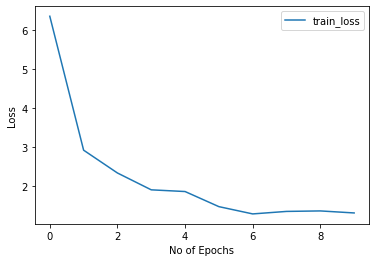

<IPython.core.display.Javascript object>

In [29]:
plt.plot(train_losses , label = 'train_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Accuracy

In [30]:
def accuracy(loader):
    n_correct = 0
    n_total = 0
    model.cuda()
    for inputs, targets in loader:
        inputs, targets = inputs.cuda(), targets.cuda()

        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc

<IPython.core.display.Javascript object>

In [31]:
train_acc = accuracy(train_loader)
test_acc = accuracy(test_loader)
validation_acc = accuracy(validation_loader)

<IPython.core.display.Javascript object>

In [32]:
print(
    f"Train Accuracy : {train_acc}\nTest Accuracy : {test_acc}\nValidation Accuracy : {validation_acc}"
)

Train Accuracy : 0.851357365376057
Test Accuracy : 0.599647266313933
Validation Accuracy : 0.6272066458982347


<IPython.core.display.Javascript object>

In [33]:
import pickle

<IPython.core.display.Javascript object>

In [34]:
with open("good_model.pkl","wb") as f:
    pickle.dump(model,f)

<IPython.core.display.Javascript object>